# Analiza posjećenosti teretana

## Uvod

Cilj ovog projekta je istražiti potencijalnu korelaciju između posjećenosti teretana i vremenskih uvjeta, kako bi se razumjelo mogu li meteorološki faktori utjecati na motivaciju ljudi za vježbanjem. Projekt se sastoji od nekoliko ključnih faza:

- Prikupljanje podataka (scraping)
- Analiza i vizualizacija
- Razvoj prediktivnog modela (machine learning)

In [ ]:
%pip install selenium
%pip install openmeteo_requests
%pip install requests_cache
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install statsmodels
%pip install scikit-learn
%pip install scipy

## 1. Scraping

U prvoj fazi, potrebno je implementirati web scraping tehniku za prikupljanje podataka o posjećenosti teretana u intervalima od 30min. Također, potrebno je istovremeno prikupiti vremenske podatke.

Posjećenost ćemo prikupiti tako što ćemo se na stranicu teretane spojiti preko headless browsera, ulogirati se i izvući potrebne podatke. Koristiti ćemo **selenium** biblioteku u Pythonu. Za vremenske podatke koristiti ćemo open-source API **open-meteo**.

U sklopu projekta scraping je proveden sa eksternom skriptom koja prikuplja podatke svakih 30 min.

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.options import Options
import openmeteo_requests
import requests_cache
from retry_requests import retry
import time
from datetime import datetime
import json

Kada smo uključili sve potrebne biblioteke, možemo početi s pisanjem ostatka koda. Za pristup stranici nam trebaju username i password koji ćemo učitati iz eksterne JSON datoteke:

In [2]:
def get_credentials():
    with open('login.json', 'r') as file:
        return json.load(file)

JSON datoteka treba biti u sljedećem formatu:

In [3]:
{
    "username": "...",
    "password": "..."
}

{'username': '...', 'password': '...'}

Idući korak je napisati glavnu scraping funkciju za podatke o teretanama:

In [61]:
def get_stats():
    # URL sa kojem scrapeamo podatke-
    url = 'https://marjan.split-fitness.club/admin/signin'

    # Postavke selenium headless browsera.
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')

    gym_a = None
    gym_b = None
    gym_c = None

    # Čitamo login info iz datoteke.
    login = get_credentials()

    try:
        browser = webdriver.Firefox(options=options)
        browser.get(url)

        # Popunjavamo login polja preko elemenata.
        email = browser.find_element(By.NAME, "email")
        password = browser.find_element(By.NAME, "password")

        email.clear()
        email.send_keys(login['username'])

        password.clear()
        password.send_keys(login['password'])

        # Simuliramo button click.
        browser.find_element(By.XPATH, "//button[@class='btn btn-dark btn-block']").click()
        time.sleep(3)
        modal = browser.find_element(By.ID, "openModal44")
        browser.execute_script("arguments[0].click()", modal)
        time.sleep(1)
        
        # Prikupljamo trenutno stanje 3 različine teretane.
        gym_a = browser.find_element(By.ID, "battery1").text
        gym_b = browser.find_element(By.ID, "battery2").text
        gym_c = browser.find_element(By.ID, "battery3").text
    except Exception as err:
        print(f"Unexpected {err=}, {type(err)=}")

    
    gym_a = int(gym_a.replace(" members", ""))
    gym_b = int(gym_b.replace(" members", ""))
    gym_c = int(gym_c.replace(" members", ""))

    return [gym_a, gym_b, gym_c]

Možemo testirati funkciju tako da je pokrenemo i ispišemo rezultate:

In [62]:
print(get_stats())

[0, 0, 16]


Sljedeći korak je pisanje funkcije za prikupljanje vremenskih podataka:

In [6]:
def get_weather():
    cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)

    # URL sa kojeg dohvaćamo vremenske podatke.
    url = "https://api.open-meteo.com/v1/forecast"

    # Specificiramo lokaciju i podatke koje želimo dohvatiti.
    params = {
        "latitude": 43.5089,
	    "longitude": 16.4392,
	    "current": ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation", "rain", "showers", "snowfall", "weather_code", "cloud_cover", "wind_speed_10m"],
	    "hourly": "uv_index"
    }
    
    responses = openmeteo.weather_api(url, params=params)

    response = responses[0]
    current = response.Current()
    
    return current

Možemo testirati funkciju:

In [7]:
data = get_weather()
key = ["temp", "rel_humidity", "apparent_temp", "precipitation", "rain", "showers", "snowfall", "weather_code", "cloud_cover", "wind_speed"]

for i in range(0, 9):
    print(key[i] + " : " + str(data.Variables(i).Value()))

temp : 11.300000190734863
rel_humidity : 57.0
apparent_temp : 8.92647933959961
precipitation : 0.0
rain : 0.0
showers : 0.0
snowfall : 0.0
weather_code : 2.0
cloud_cover : 76.0


## 2. Analiza i vizualizacija

Kada smo prikupili dovoljno podataka, možemo ih vizualizirati. Potrebne su nam biblioteke *matplotlib, seaborn, numpy* i *pandas*. 

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

Prvo moramo učitati i pripremiti podatke:

In [9]:
data_path = 'data.csv'
df = pd.read_csv(data_path)
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df['Hour'] = df['DateTime'].dt.hour

average_attendance = df.groupby(['Day', 'Hour']).agg({'GymA':'mean', 'GymB':'mean', 'GymC':'mean'}).reset_index()
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
average_attendance['Day'] = pd.Categorical(average_attendance['Day'], categories=days_order, ordered=True)
average_attendance.sort_values(by=['Day', 'Hour'], inplace=True)

Zanima nas prosječna broj ljudi u teretani svakih 30min na različite dane u tjednu:

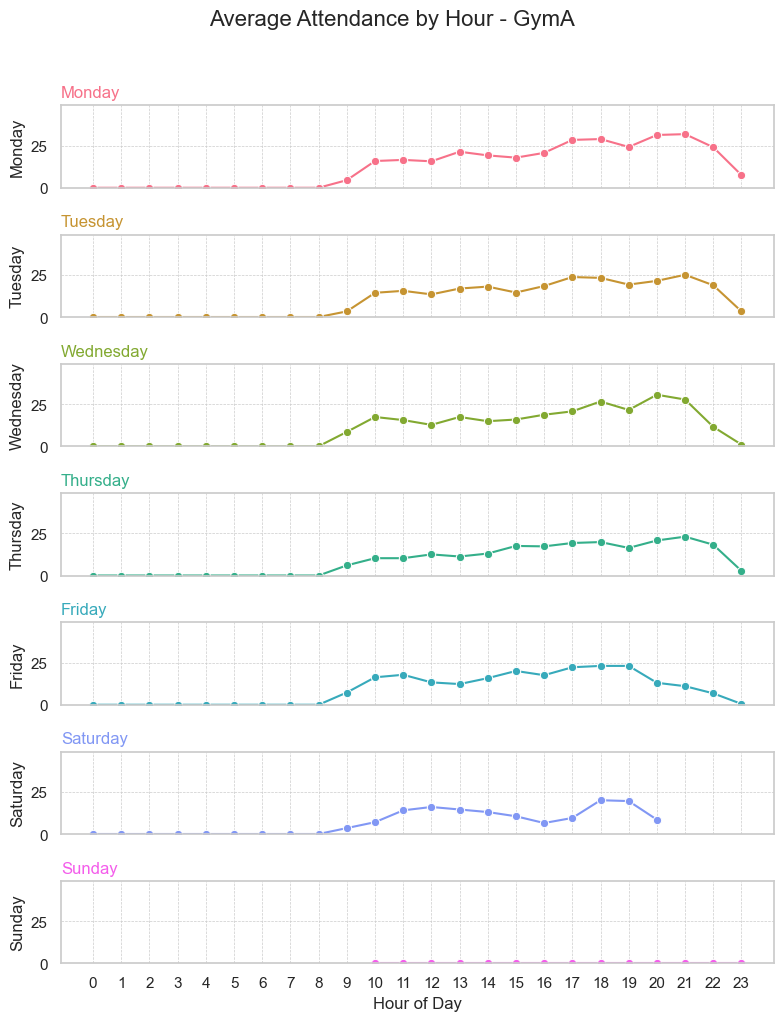

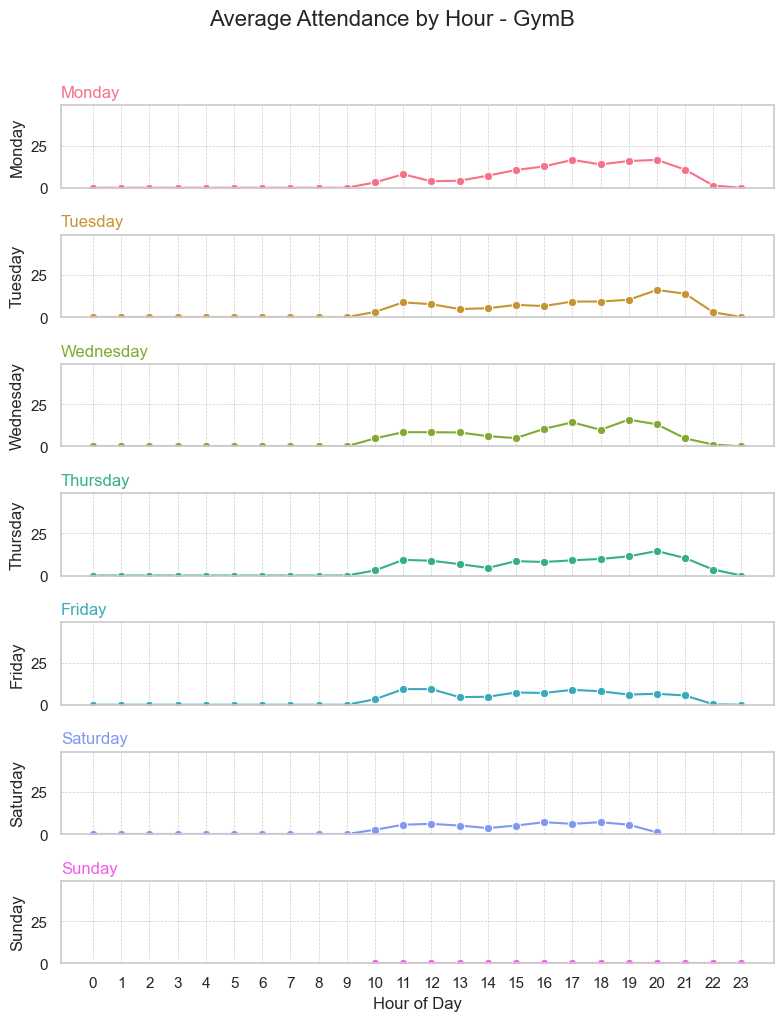

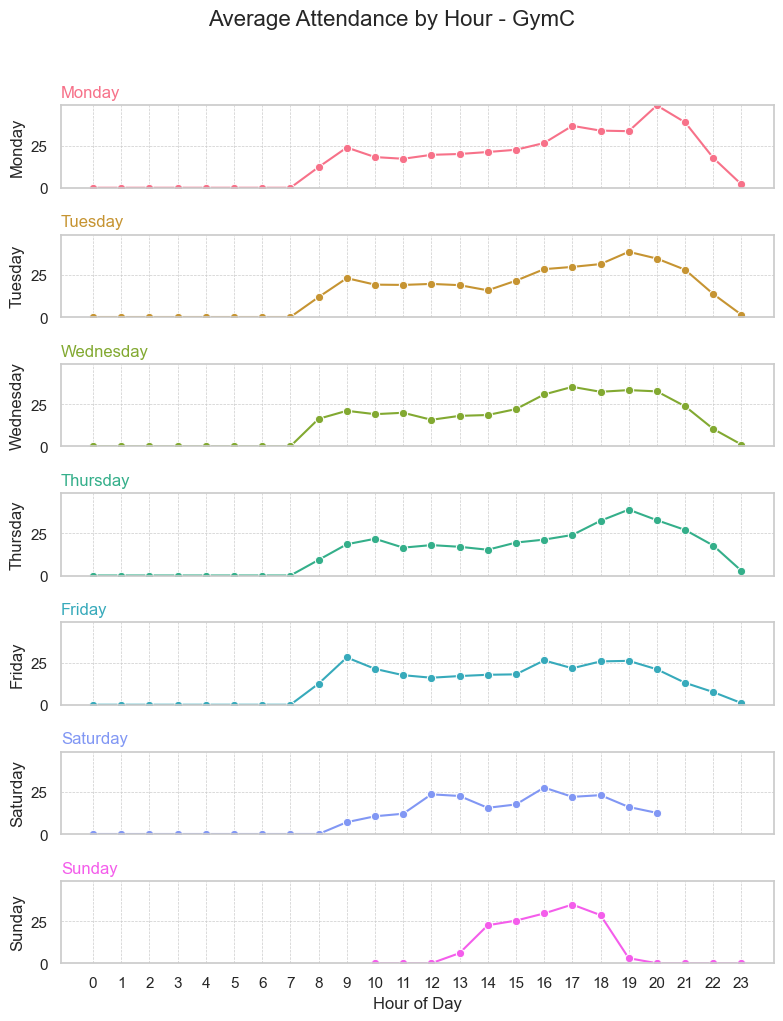

In [10]:
max_attendance = average_attendance[['GymA', 'GymB', 'GymC']].max().max()

def plot_attendance_by_day_fixed_y(gym_name, max_y):
    gym_data = average_attendance.pivot(index='Hour', columns='Day', values=gym_name).reindex(columns=days_order)
    sns.set(style="whitegrid", palette="muted")

    fig, axes = plt.subplots(7, 1, figsize=(8, 10), sharex=True)
    fig.suptitle(f'Average Attendance by Hour - {gym_name}', fontsize=16, y=1.02)

    for i, day in enumerate(days_order):
        sns.lineplot(data=gym_data[day], ax=axes[i], color=sns.color_palette("husl", 7)[i], marker='o')
        axes[i].set_title(day, fontsize=12, loc='left', color=sns.color_palette("husl", 7)[i])
        axes[i].set_ylim(bottom=0, top=max_y)
        axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)

    axes[-1].set_xlabel('Hour of Day', fontsize=12)
    plt.xticks(np.arange(0, 24, 1))
    plt.tight_layout()

for gym in ['GymA', 'GymB', 'GymC']:
    plot_attendance_by_day_fixed_y(gym, max_attendance)

Možemo provjeriti korelaciju između posjećenosti i vremenskih uvjeta :

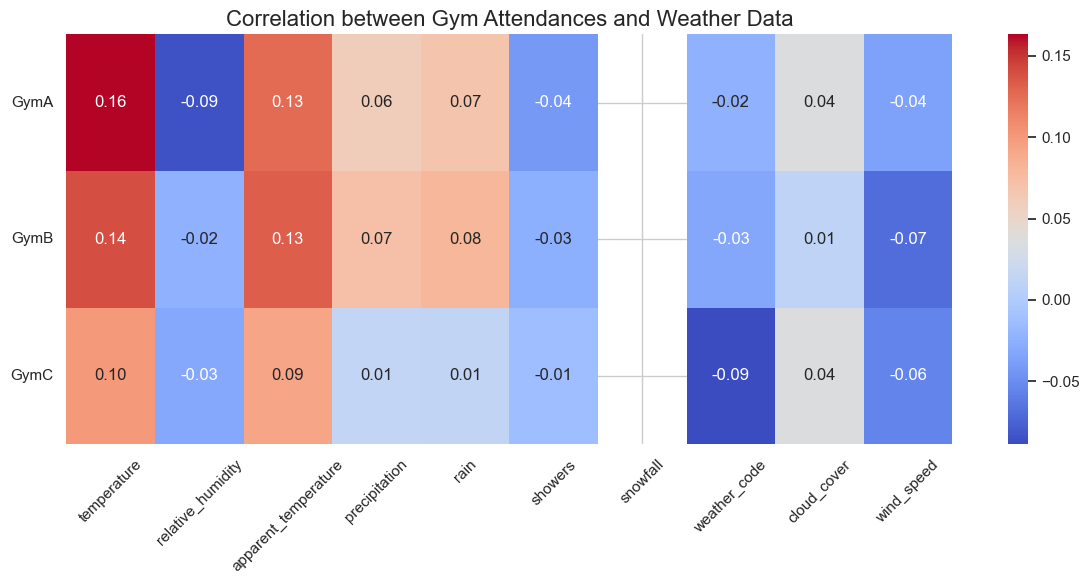

In [11]:
gym_weather_correlation = df[['GymA', 'GymB', 'GymC', 'temperature', 'relative_humidity', 
                              'apparent_temperature', 'precipitation', 'rain', 'showers', 
                              'snowfall', 'weather_code', 'cloud_cover', 'wind_speed']].corr().loc['GymA':'GymC', 'temperature':'wind_speed']

plt.figure(figsize=(12, 6))
sns.heatmap(gym_weather_correlation, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation between Gym Attendances and Weather Data', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

Vidimo da se jedino korelacija sa temperaturom ističe, iako je i ona dosta niska. Scraping bi trebalo provesti kroz neki duži period kako bi se obuhvatile veće promjene temperature, jer trenutno baratamo dosta malim rasponom temperatura pa ne možemo zaključiti imamo li znatnu korelaciju. Svakako, možemo probati vizualizirati broj ljudi u teretani u ovisnosti o vremenu dana i temperaturi:

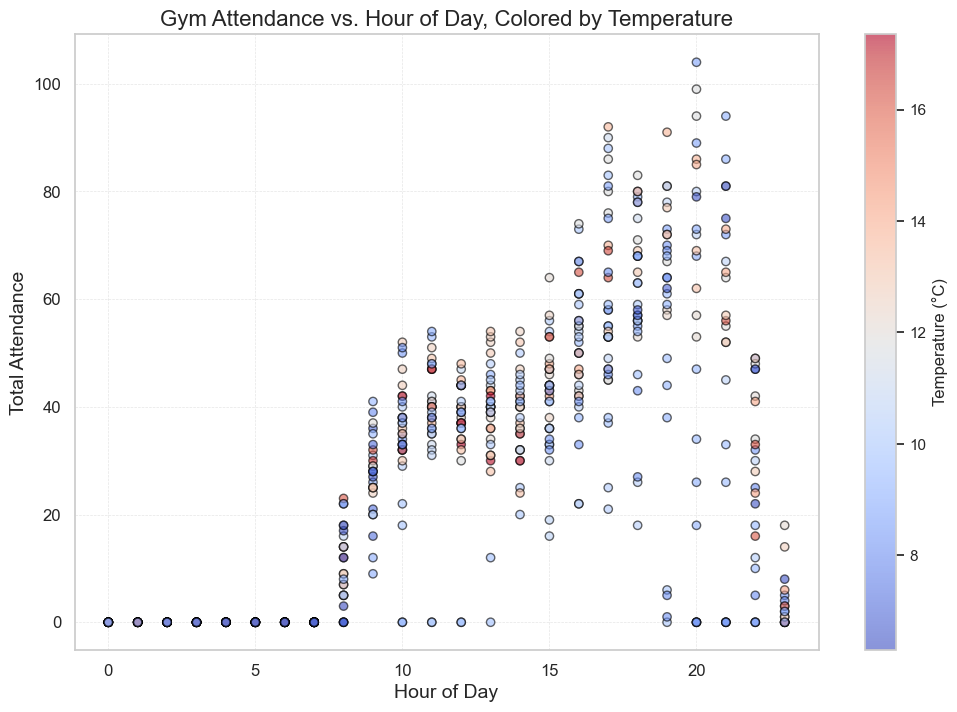

In [12]:
plt.figure(figsize=(12, 8))

df['TotalAttendance'] = df['GymA'] + df['GymB'] + df['GymC']

scatter = plt.scatter(x=df['Hour'], y=df['TotalAttendance'],
                      c=df['temperature'], cmap='coolwarm', alpha=0.6, edgecolors='black')

plt.colorbar(scatter, label='Temperature (°C)')

plt.title('Gym Attendance vs. Hour of Day, Colored by Temperature', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Total Attendance', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

Boxplot za detaljnije statistički prikaz podataka za sve 3 lokacije:

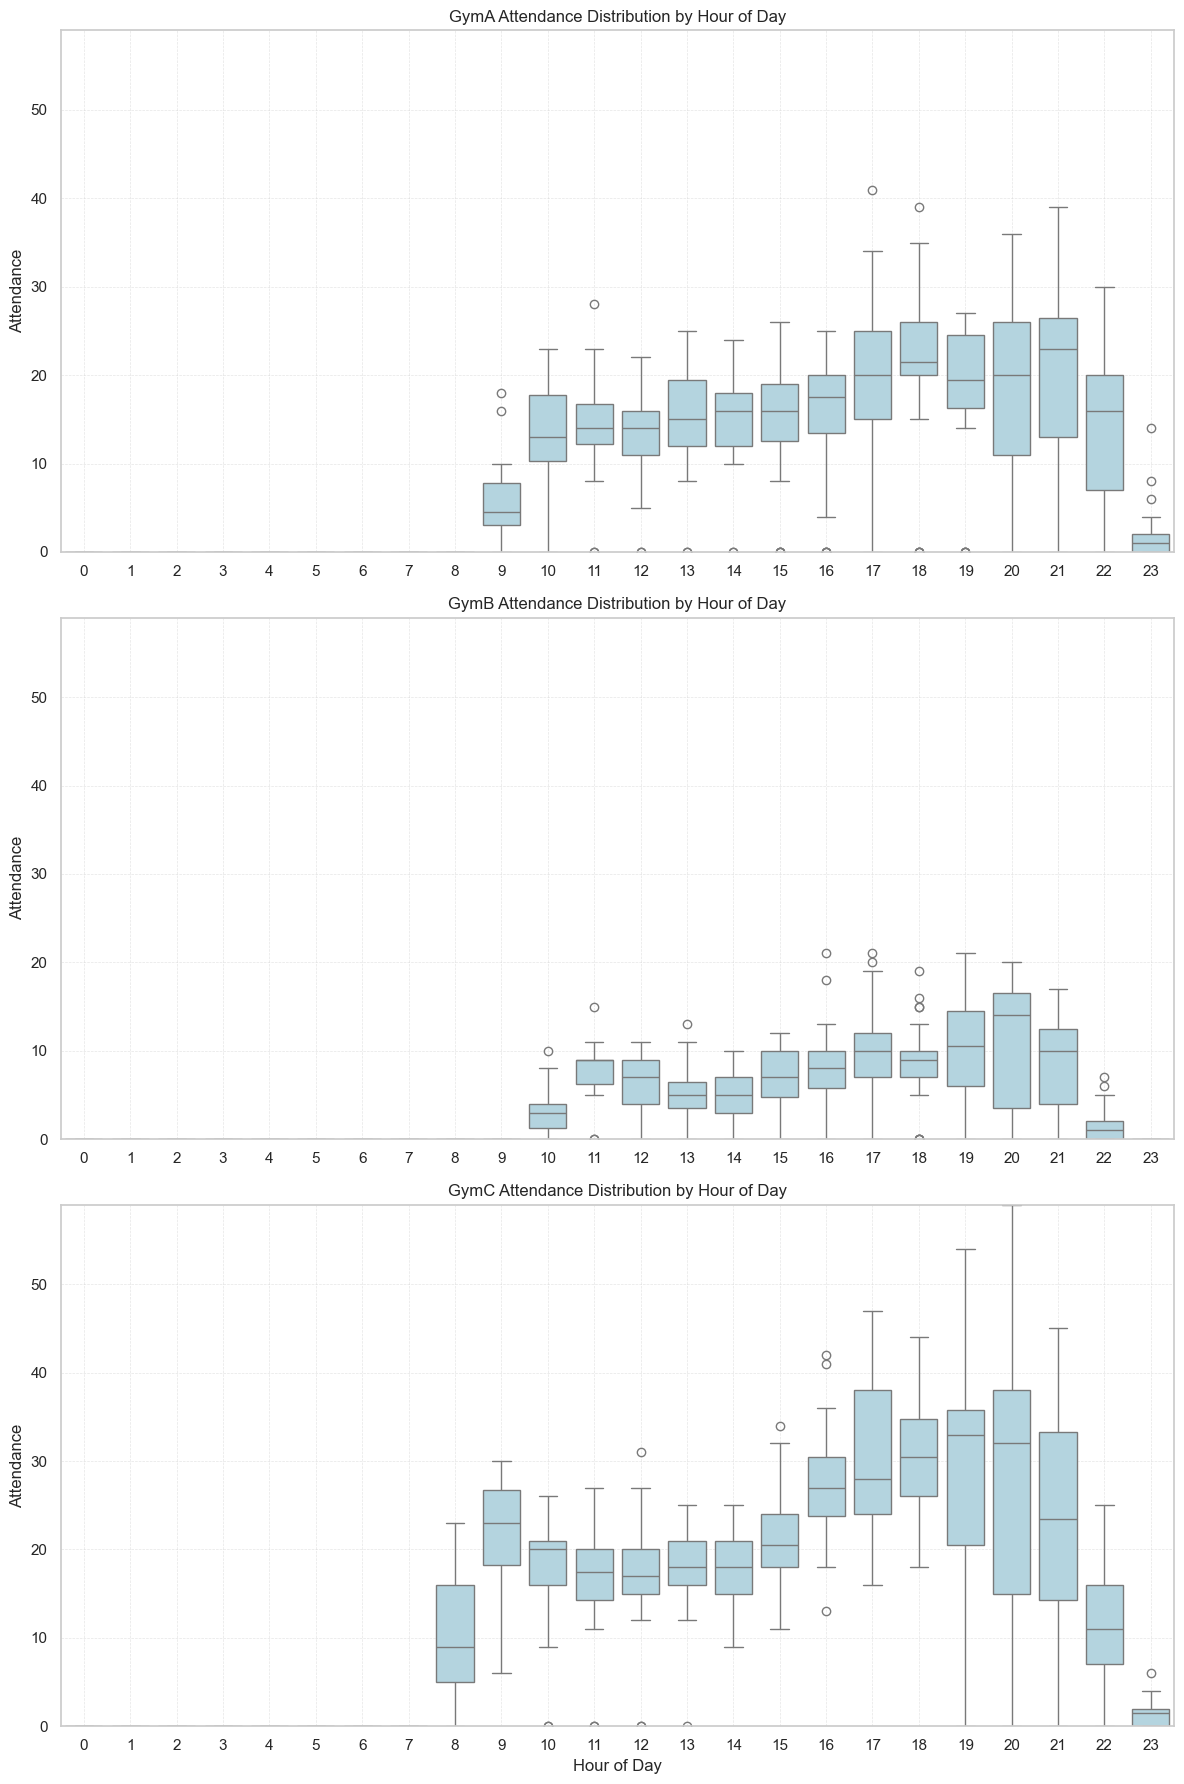

In [13]:
max_attendance = df[['GymA', 'GymB', 'GymC']].max().max()

plt.figure(figsize=(12, 18))

for i, gym in enumerate(['GymA', 'GymB', 'GymC'], start=1):
    plt.subplot(3, 1, i) 
    sns.boxplot(x='Hour', y=gym, data=df, color="lightblue")
    plt.ylim(0, max_attendance) 
    plt.title(f'{gym} Attendance Distribution by Hour of Day')
    plt.xlabel('Hour of Day' if i == 3 else '') 
    plt.ylabel('Attendance')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()

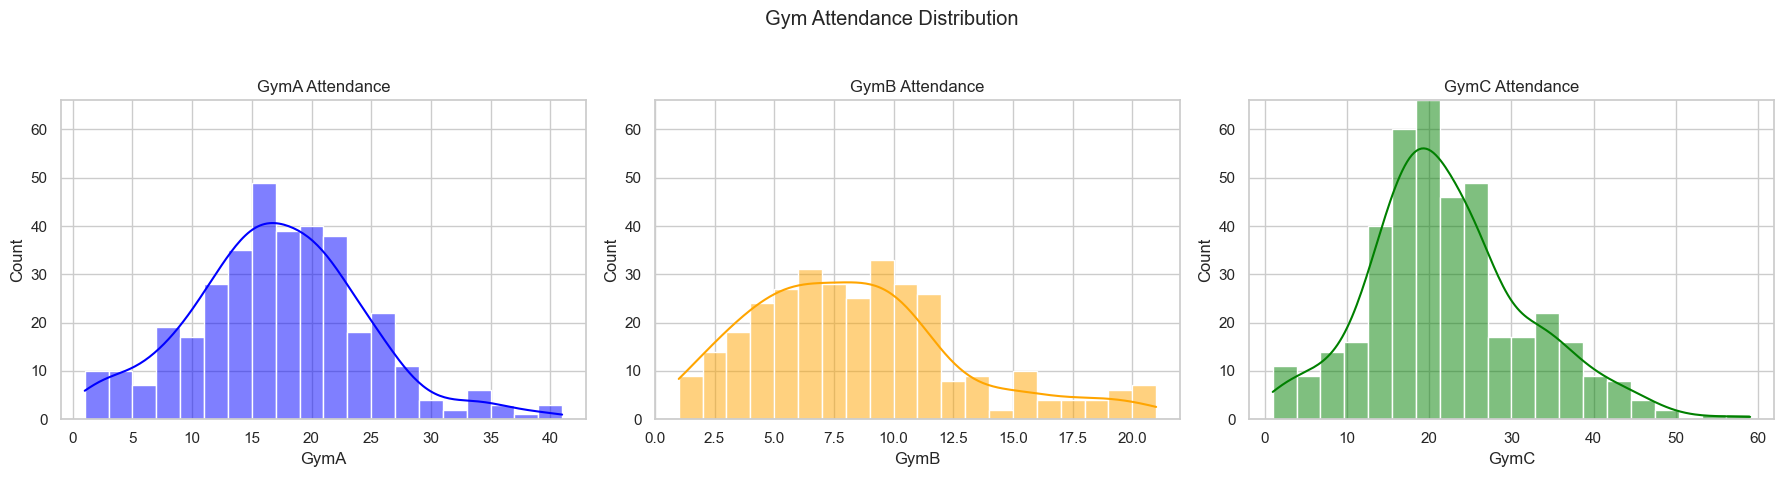

In [14]:
filtered_gymA = df[df['GymA'] > 0]['GymA']
filtered_gymB = df[df['GymB'] > 0]['GymB']
filtered_gymC = df[df['GymC'] > 0]['GymC']

counts_gymA, _ = np.histogram(filtered_gymA, bins=20)
counts_gymB, _ = np.histogram(filtered_gymB, bins=20)
counts_gymC, _ = np.histogram(filtered_gymC, bins=20)

max_bin_count = max(counts_gymA.max(), counts_gymB.max(), counts_gymC.max())

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Gym Attendance Distribution')

sns.histplot(filtered_gymA, bins=20, kde=True, ax=axes[0], color='blue').set_title('GymA Attendance')
axes[0].set_ylim([0, max_bin_count])

sns.histplot(filtered_gymB, bins=20, kde=True, ax=axes[1], color='orange').set_title('GymB Attendance')
axes[1].set_ylim([0, max_bin_count])

sns.histplot(filtered_gymC, bins=20, kde=True, ax=axes[2], color='green').set_title('GymC Attendance')
axes[2].set_ylim([0, max_bin_count])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [15]:
stats = pd.DataFrame({
    'GymA': {
        'Mean': filtered_gymA.mean(),
        'Variance': filtered_gymA.var(),
        'Median': filtered_gymA.median(),
        'Std Deviation': filtered_gymA.std()
    },
    'GymB': {
        'Mean': filtered_gymB.mean(),
        'Variance': filtered_gymB.var(),
        'Median': filtered_gymB.median(),
        'Std Deviation': filtered_gymB.std()
    },
    'GymC': {
        'Mean': filtered_gymC.mean(),
        'Variance': filtered_gymC.var(),
        'Median': filtered_gymC.median(),
        'Std Deviation': filtered_gymC.std()
    }
}).transpose()

print(stats)

           Mean   Variance  Median  Std Deviation
GymA  17.022099  53.694801    17.0       7.327674
GymB   8.264984  19.809308     8.0       4.450765
GymC  22.196078  94.447945    21.0       9.718433


Spearmanova korelacija je ne-parametarska mjera statističke ovisnosti između dviju varijabli. Za razliku od Pearsonove korelacije, koja mjeri linearnu vezu između dviju kontinuiranih varijabli, Spearmanova korelacija ocjenjuje koliko dobro veza između dviju varijabli može biti opisana pomoću monotone funkcije. Drugim riječima, Spearmanova korelacija mjeri snagu i smjer veze između rangova dviju varijabli.

Spearmanova korelacija je posebno korisna kada su podaci ne-normirani ili kada odnos između varijabli nije linearan. Osim toga, može se koristiti kada su podaci na ordinalnoj skali. Koeficijent Spearmanove korelacije kreće se od -1 do 1, gdje 1 označava savršenu pozitivnu korelaciju rangova, -1 savršenu negativnu korelaciju rangova, a 0 označava da nema korelacije.

Spearmanovu korelaciju možemo primijeniti na naše podatke:

In [31]:
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats

if 'TotalAttendance' not in df.columns:
    df['TotalAttendance'] = df['GymA'] + df['GymB'] + df['GymC']

correlation, p_value = stats.spearmanr(df['temperature'], df['TotalAttendance'])

print(f"Spearman's Rank Correlation: {correlation}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant correlation between temperature and gym attendance.")
    if correlation > 0:
        print("The correlation is positive, meaning higher temperatures are associated with higher attendance.")
    else:
        print("The correlation is negative, meaning higher temperatures are associated with lower attendance.")
else:
    print("There is no statistically significant correlation between temperature and gym attendance.")

Spearman's Rank Correlation: 0.17654965604124814
P-value: 2.1702019025623297e-05
There is a statistically significant correlation between temperature and gym attendance.
The correlation is positive, meaning higher temperatures are associated with higher attendance.


Rezultat ukazuje na statistički značajnu iako slabu korelaciju broja ljudi u teretanama sa temperaturom. S porastom temperature raste i broj posjećenosti. Odnos možemo testirati i regresijom (Ordinary Least Squares):

In [ ]:
X = df[['temperature']]
y = df['TotalAttendance']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())


print("\nInterpretation & Considerations:")

# R-squared and Adjusted R-squared
if model.rsquared > 0.5:
    print("- The model explains a significant portion of the variance in total gym attendance.")
else:
    print("- The model does not explain much variance in total gym attendance, suggesting additional variables might be needed.")

# F-statistic and its p-value
if model.f_pvalue < 0.05:
    print("- The model is statistically significant, indicating a relationship between temperature and total gym attendance.")
else:
    print("- The model is not statistically significant, suggesting no linear relationship between temperature and total gym attendance.")

# Coefficients interpretation
print("- Coefficients:")
for coef in model.params.index:
    if model.pvalues[coef] < 0.05:
        print(f"- {coef} is statistically significant, indicating a meaningful contribution to the model.")
    else:
        print(f"- {coef} is not statistically significant, suggesting it may not contribute meaningfully to the model.")

# Durbin-Watson test for autocorrelation
dw_statistic = durbin_watson(model.resid)
print("- Durbin-Watson statistic for checking autocorrelation in the residuals:", dw_statistic)
if 1.5 < dw_statistic < 2.5:
    print("- The residuals are independent, indicating no autocorrelation.")
else:
    print("- There may be autocorrelation in the residuals, which could affect the reliability of the model.")


                            OLS Regression Results                            
Dep. Variable:        TotalAttendance   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     11.69
Date:                Sun, 18 Feb 2024   Prob (F-statistic):           0.000675
Time:                        20:10:38   Log-Likelihood:                -2667.0
No. Observations:                 572   AIC:                             5338.
Df Residuals:                     570   BIC:                             5347.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          15.4695      4.721      3.277      

Omjer broja ljudi na sve 3 lokacije u ovisnosti o dobu dana:

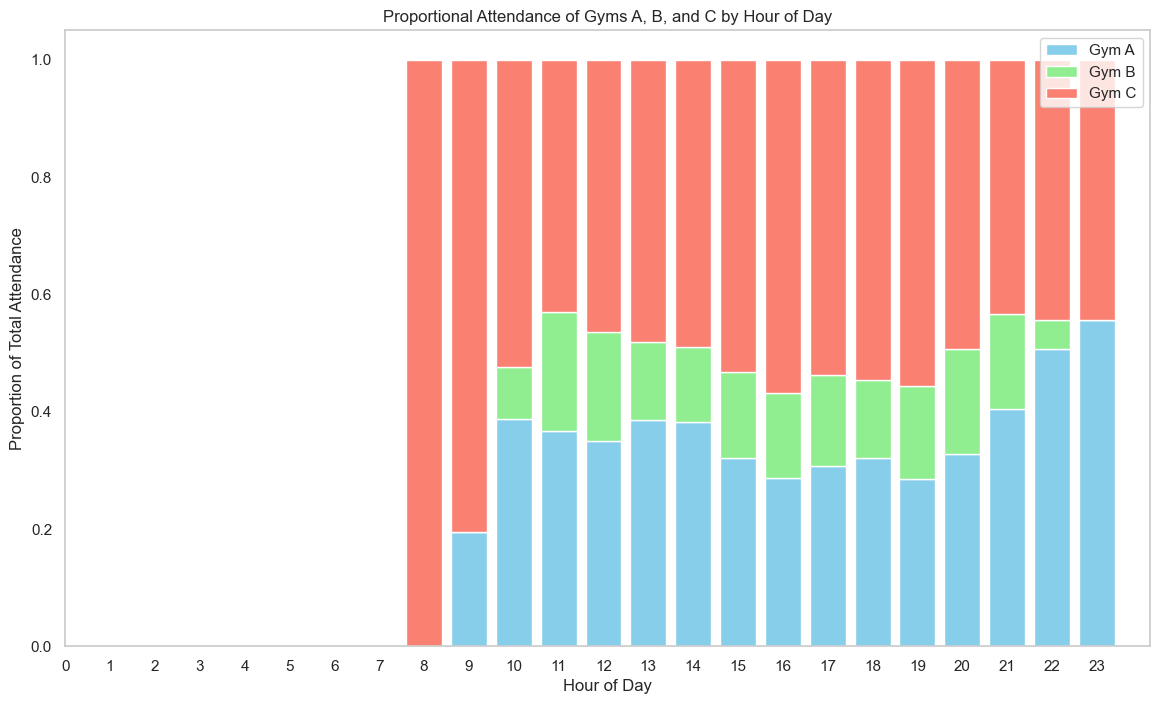

In [ ]:
df['GymARatio'] = df['GymA'] / df['TotalAttendance']
df['GymBRatio'] = df['GymB'] / df['TotalAttendance']
df['GymCRatio'] = df['GymC'] / df['TotalAttendance']

hours = sorted(df['Hour'].unique())
gym_a_ratios = [df[df['Hour'] == hour]['GymARatio'].mean() for hour in hours]
gym_b_ratios = [df[df['Hour'] == hour]['GymBRatio'].mean() for hour in hours]
gym_c_ratios = [df[df['Hour'] == hour]['GymCRatio'].mean() for hour in hours]

plt.figure(figsize=(14, 8))
plt.bar(hours, gym_a_ratios, label='Gym A', color='skyblue')
plt.bar(hours, gym_b_ratios, bottom=gym_a_ratios, label='Gym B', color='lightgreen')
bottom_ratios = [a + b for a, b in zip(gym_a_ratios, gym_b_ratios)]
plt.bar(hours, gym_c_ratios, bottom=bottom_ratios, label='Gym C', color='salmon')

plt.title('Proportional Attendance of Gyms A, B, and C by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Proportion of Total Attendance')
plt.xticks(hours)
plt.legend()
plt.grid(visible=False)

plt.show()

## 3. Predikcijski model

Za stvaranje predikcijskog modela pomoću strojnog učenja koristit ćemo Random Forest regresiju. Ona koristiti skup odlučujućih stabala za predviđanje kontinuirane ciljne varijable. Temelji se na algoritmu Random Forest, gdje se više modela trenira paralelno za riješavanje istog problema te se rezultati kombiniraju za konačan odgovor. U kontekstu regresije, konačna predikcija dobiva se usrednjavanjem predikcija svih odlučujućih stabala unutar šume.

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import datetime
import requests
from scraper import get_stats

def info(message):
    print(f"[  INFO  ]\t{message}")

Pripremamo podatke:

In [32]:
info("Reading CSV file...")
df = pd.read_csv('data.csv')

info("Preprocessing data...")
df[(df['GymA'] != 0) | (df['GymB'] != 0) | (df['GymC'] != 0)]
df['Day'] = pd.Categorical(df['Day'])
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df['Hour'] = df['DateTime'].dt.hour
df['Month'] = df['DateTime'].dt.month
df['Weekday'] = df['DateTime'].dt.weekday
df.drop(['Date', 'Time', 'DateTime'], axis=1, inplace=True)

feature_cols = ['temperature', 'relative_humidity', 'apparent_temperature', 'precipitation', 
                'rain', 'showers', 'snowfall', 'weather_code', 'cloud_cover', 
                'wind_speed', 'Hour', 'Month', 'Weekday']
target_cols = ['GymA', 'GymB', 'GymC']

[  INFO  ]	Reading CSV file...
[  INFO  ]	Preprocessing data...


Dijelimo dataset u train i test datasetove:

In [33]:
info("Splitting dataset...")
# Splitting the data into features (X) and targets (y)
X = df[feature_cols]
y = df[target_cols]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training the model
info("Training the model...")
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

info("Evaluating the model...")
# Evaluating the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
info("Mean squared error: " + str(mse))


[  INFO  ]	Splitting dataset...
[  INFO  ]	Training the model...
[  INFO  ]	Evaluating the model...
[  INFO  ]	Mean squared error: 13.46356831025989


Nadograditi ćemo funkciju za dohvaćanje podataka o vremenu da podržava prognozu ovisno o specificiranom vremenu:

In [64]:
# Ovdje možemo specificirati točno vrijeme koje nas zanima.
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")
current_hour = now.hour

def get_weather_forecast(latitude, longitude, current_hour):

    url = f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&hourly=temperature_2m,relativehumidity_2m,precipitation,weathercode,cloudcover,windspeed_10m"

    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Error fetching data from Open-Meteo: {response.status_code}")

    data = response.json()

    forecast = data['hourly']
    current_weather = {
        'temperature': forecast['temperature_2m'][current_hour],
        'relative_humidity': forecast['relativehumidity_2m'][current_hour],
        'precipitation': forecast['precipitation'][current_hour],
        'weather_code': forecast['weathercode'][current_hour],
        'cloud_cover': forecast['cloudcover'][current_hour],
        'wind_speed': forecast['windspeed_10m'][current_hour],
        'rain': 0,
        'showers': 0,
        'snowfall': 0,
        'Hour': current_hour,
        'Month': now.month,
        'Weekday': now.weekday()
    }
    

    return current_weather

Sada pišemo funkciju za predikciju:

In [65]:
def predict_gym_attendance(forecast_data):
    required_features = ['temperature', 'relative_humidity', 'apparent_temperature', 
                         'precipitation', 'rain', 'showers', 'snowfall', 
                         'weather_code', 'cloud_cover', 'wind_speed', 
                         'Hour', 'Month', 'Weekday']
    
    forecast_df = pd.DataFrame(columns=required_features)

    for feature in required_features:
        if feature in forecast_data:
            forecast_df.at[0, feature] = forecast_data[feature]
        else:
            forecast_df.at[0, feature] = 0 

    predicted_attendance = model.predict(forecast_df)
    return predicted_attendance

Kada imamo sve potrebne funkcije, možemo napraviti predikciju:

In [66]:
# Split
latitude = 43.5089 
longitude = 16.4392

info("Getting current weather...")
forecast_data = get_weather_forecast(latitude, longitude, current_hour=current_hour)

info("Making a prediction...")
attendance_prediction = predict_gym_attendance(forecast_data)

gym_a_predicted = round(attendance_prediction[0][0])
gym_b_predicted = round(attendance_prediction[0][1])
gym_c_predicted = round(attendance_prediction[0][2])

info("Scraping actual data...")
actual_data = get_stats()

info("Done!")
print()

for i in range(0, 3):
    temp = round(attendance_prediction[0][i])
    width = int(max(temp, actual_data[i]))
    print(f"\t\tLocation {i} predicted:\t{temp}")
    print(f"\t\tLocation {i} actual:\t{actual_data[i]}")
    print()

[  INFO  ]	Getting current weather...
[  INFO  ]	Making a prediction...
[  INFO  ]	Scraping actual data...
[  INFO  ]	Done!

		Location 0 predicted:	0
		Location 0 actual:	0

		Location 1 predicted:	0
		Location 1 actual:	0

		Location 2 predicted:	10
		Location 2 actual:	16



Možemo vizualizirati predikciju i stvarno stanje:

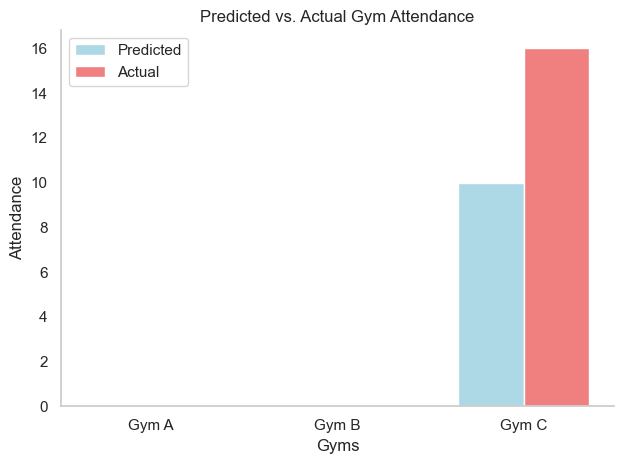

In [67]:
predicted_data = [gym_a_predicted, gym_b_predicted, gym_c_predicted]
gyms = ['Gym A', 'Gym B', 'Gym C']

# Setting up the plot
indices = np.arange(len(gyms))
bar_width = 0.35

fig, ax = plt.subplots()
predicted_bars = ax.bar(indices - bar_width/2, predicted_data, bar_width, label='Predicted', color='#add8e6')
actual_bars = ax.bar(indices + bar_width/2, actual_data, bar_width, label='Actual', color='#f08080')

ax.set_xlabel('Gyms')
ax.set_ylabel('Attendance')
ax.set_title('Predicted vs. Actual Gym Attendance')
ax.set_xticks(indices)
ax.set_xticklabels(gyms)
ax.legend()

ax.set_facecolor('white')
ax.grid(False) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Ako želimo predvidjeti posjećenost u x sati, možemo forecast funkciji poslati željeno vrijeme:

In [86]:
# current_hour = now.hour

# forecast_data = get_weather_forecast(latitude, longitude, current_hour=current_hour)
# attendance_prediction = predict_gym_attendance(forecast_data)
# actual_data = get_stats()

# multipliers = []

# for i in range(0, 3):
#    if attendance_prediction[0][i] == 0 or actual_data[i] == 0:
#       multipliers.append(1)
#    else:
#        multipliers.append(attendance_prediction[0][i] / actual_data[i])

current_hour = 12

info("Getting weather forecast at specified time...")
forecast_data = get_weather_forecast(latitude, longitude, current_hour=current_hour)

info("Making a prediction...")
attendance_prediction = predict_gym_attendance(forecast_data)

print()
print(attendance_prediction[0])

# print()
# print("Adjusted for today:")
# adjusted = []

# for i in range(0, 3):
#     adjusted.append(attendance_prediction[0][i]/multipliers[i])

# print(adjusted)


[  INFO  ]	Getting weather forecast at specified time...
[  INFO  ]	Making a prediction...

[13.69183333  7.29216667 21.39766667]
